In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import random

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import transforms

# Conflict check visualization

In [40]:
conflict_resolution_log = pd.read_csv('conflict_resolution_log.csv')

In [41]:
conflict_resolution_log

,conflict_idx,lidar,action_steer,action_speed
0,1,[ 3.01588662 3.01310549 2.92437485 2.914327...,0.101254,6.246841
1,1,[ 3.01412899 2.95217388 2.93283566 2.890607...,0.138007,6.258821
2,2,[ 3.01588662 3.01310549 2.92437485 2.914327...,0.101254,6.246841
3,2,[ 3.01412899 2.95217388 2.93283566 2.890607...,0.138007,6.258821
4,3,[ 3.01167543 2.98242244 2.93004736 2.895400...,0.092373,6.254828
...,...,...,...,...
260711,42713,[1.56181595 1.49441742 1.44309872 1.43834626 1...,0.105434,8.000000
260712,42714,[1.42028565 1.35700798 1.30069473 1.30770616 1...,0.089494,8.000000
260713,42714,[1.55068943 1.51119041 1.49127144 1.37849247 1...,-0.002432,8.000000
260714,42714,[1.58753722 1.43287992 1.43453248 1.36746053 1...,0.084699,8.000000


In [42]:
sample_conflict_id = []
for i in range(10):
    sample_conflict_id.append(random.randint(0, 42713))

In [82]:
sample_conflict_id

[11102, 40287, 6510, 31881, 23015, 16728, 24902, 9131, 15900, 4274]

In [44]:
lidar_converted_conflict_log = conflict_resolution_log.copy()
lidar_converted_conflict_log['lidar'] = lidar_converted_conflict_log['lidar'].apply(lambda x: 
                                        np.fromstring(
                                                        x.replace('\n','')
                                                        .replace('[','')
                                                        .replace(']','')
                                                        .replace('  ',' '), sep=' '))

In [45]:
lidar_converted_conflict_log

,conflict_idx,lidar,action_steer,action_speed
0,1,"[3.01588662, 3.01310549, 2.92437485, 2.9143273...",0.101254,6.246841
1,1,"[3.01412899, 2.95217388, 2.93283566, 2.8906070...",0.138007,6.258821
2,2,"[3.01588662, 3.01310549, 2.92437485, 2.9143273...",0.101254,6.246841
3,2,"[3.01412899, 2.95217388, 2.93283566, 2.8906070...",0.138007,6.258821
4,3,"[3.01167543, 2.98242244, 2.93004736, 2.8954002...",0.092373,6.254828
...,...,...,...,...
260711,42713,"[1.56181595, 1.49441742, 1.44309872, 1.4383462...",0.105434,8.000000
260712,42714,"[1.42028565, 1.35700798, 1.30069473, 1.3077061...",0.089494,8.000000
260713,42714,"[1.55068943, 1.51119041, 1.49127144, 1.3784924...",-0.002432,8.000000
260714,42714,"[1.58753722, 1.43287992, 1.43453248, 1.3674605...",0.084699,8.000000


In [46]:
test_vis_lidar = lidar_converted_conflict_log.iloc[lidar_converted_conflict_log.index==0]['lidar'][0].copy()

In [47]:
def recover_pos_pt_from_ray(theta_index, sines, cosines, ray_dist):
    theta_index_ = int(theta_index)
    s = sines[theta_index_]
    c = cosines[theta_index_]

    x = ray_dist * c
    y = ray_dist * s

    return x, y

In [48]:
def vis_lidar(lidar, ax=None, rot=False):
    # Convert lidar scan to position points in local frame
    
    theta_dis = 2000
    fov = 4.7
    num_beams = 1080
    num_beams_after_downsampling = 108

    pos_pts = np.empty((num_beams_after_downsampling, 2))

    angle_increment = fov / (num_beams - 1)
    angle_increment_after_downsampling = fov / (num_beams_after_downsampling - 1)

    theta_index_increment = theta_dis * angle_increment / (2. * np.pi)
    theta_index_increment_after_downsampling = theta_dis * angle_increment_after_downsampling / (2. * np.pi)

    theta_index = theta_dis * (np.pi - fov / 2.) / (2. * np.pi)

    theta_index = np.fmod(theta_index, theta_dis)

    
    theta_arr = np.linspace(0.0, 2*np.pi, num=theta_dis)
    sines = np.sin(theta_arr)
    cosines = np.cos(theta_arr)
    eps = 0.0001

    while (theta_index < 0):
        theta_index += theta_dis

    for i in range(0, num_beams_after_downsampling):
        pos_pts[i, :] = recover_pos_pt_from_ray(theta_index, sines, cosines, lidar[i])
        theta_index += theta_index_increment_after_downsampling

        while theta_index >= theta_dis:
            theta_index -= theta_dis


    # Visualize

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))

    if rot:
        ax.set_xlim(-7.7, 7.7)
        ax.set_ylim(-5.5, 5)
    else:
        ax.set_xlim(-7.5, 2.0)
        ax.set_ylim(-3.5, 3,5)

    if rot:
        ax.scatter(pos_pts[:, 1], pos_pts[:, 0], c='b', s=1)
    else:
        ax.scatter(pos_pts[:, 0], pos_pts[:, 1], c='b', s=1)

    ax.set_aspect('equal')
    return ax

/tmp/ipykernel_7629/3540318241.py:48: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-3.5, 3,5)


<AxesSubplot: >

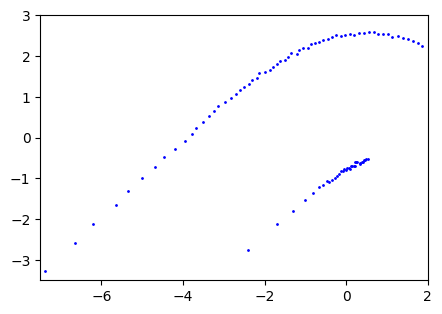

In [49]:
vis_lidar(test_vis_lidar)

In [50]:
sample_1 = lidar_converted_conflict_log.loc[lidar_converted_conflict_log['conflict_idx']==sample_conflict_id[2]]
sample_2 = lidar_converted_conflict_log.loc[lidar_converted_conflict_log['conflict_idx']==sample_conflict_id[4]]
sample_3 = lidar_converted_conflict_log.loc[lidar_converted_conflict_log['conflict_idx']==sample_conflict_id[6]]
sample_4 = lidar_converted_conflict_log.loc[lidar_converted_conflict_log['conflict_idx']==sample_conflict_id[8]]
sample_5 = lidar_converted_conflict_log.loc[lidar_converted_conflict_log['conflict_idx']==sample_conflict_id[9]]

In [51]:
sample_1

,conflict_idx,lidar,action_steer,action_speed
35618,6510,"[2.48724101, 2.42116905, 2.26606404, 2.2472723...",-0.016727,8.0
35619,6510,"[2.63772109, 2.47750945, 2.39710262, 2.2362593...",-0.045751,8.0
35620,6510,"[2.51467066, 2.46359055, 2.29192339, 2.2801380...",-0.038445,8.0
35621,6510,"[2.60082989, 2.39714784, 2.32034726, 2.2249068...",1.672580,8.0
35622,6510,"[2.50424905, 2.37551274, 2.26621344, 2.1161900...",-0.041100,8.0
35623,6510,"[2.4645661, 2.40757649, 2.22531111, 2.16750183...",-0.045165,8.0
35624,6510,"[2.4624291, 2.32623606, 2.2337286, 2.16716116,...",-0.031273,8.0


In [52]:
sample_1_selected_row_1 = sample_1.iloc[sample_1.index==35621]
sample_1_selected_row_2 = sample_1.iloc[sample_1.index==35618]
sample_1_selected_row_1

,conflict_idx,lidar,action_steer,action_speed
35621,6510,"[2.60082989, 2.39714784, 2.32034726, 2.2249068...",1.67258,8.0


In [53]:
sample_1_selected_row_1_lidar = sample_1_selected_row_1['lidar'][35621]
sample_1_selected_row_1_lidar
sample_2_selected_row_2_lidar = sample_1_selected_row_2['lidar'][35618]
sample_2_selected_row_2_lidar

array([ 2.48724101,  2.42116905,  2.26606404,  2.24727231,  2.12296315,
        1.97656729,  1.94870517,  1.91839824,  1.8257359 ,  1.79714634,
        1.7997097 ,  1.75179077,  1.65734873,  1.62497886,  1.6532113 ,
        1.65051565,  1.61306173,  1.59772735,  1.63168154,  1.61217008,
        1.61988104,  1.59318196,  1.54782363,  1.63906353,  1.61601845,
        1.61590096,  1.61912397,  1.60540241,  1.68716729,  1.71322631,
        1.72741152,  1.71560946,  1.82489295,  1.86261345,  1.92828564,
        1.94245543,  2.05619472,  2.10651447,  2.24435233,  2.31803686,
        2.33964608,  2.53844978,  2.71190481,  2.88749683,  3.07874159,
        3.35890075,  3.63253018,  4.00518034,  4.38073189,  4.92552586,
        5.79874331,  6.62539049,  8.20787189,  9.51123938, 10.21884464,
       10.71458553, 11.11882485, 11.40318576, 11.6479554 , 11.79956466,
       11.91234543,  7.51872735,  6.18068069,  5.31546225,  4.62283266,
        4.02997663,  3.72988901,  3.39612361,  3.08651946,  2.81

/tmp/ipykernel_7629/3540318241.py:48: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-3.5, 3,5)


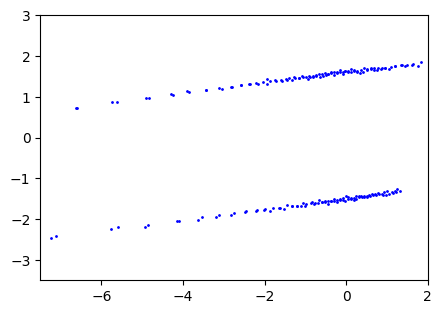

In [54]:
sample_1_graph = vis_lidar(sample_1_selected_row_1_lidar, ax=None)
sample_1_graph = vis_lidar(sample_2_selected_row_2_lidar, ax=sample_1_graph)

In [76]:
def get_pt_from_steer_angle_and_plot_as_vector(steer_angle, ax=None, color='r', rot=False):
    x = 0.0
    y = 0.0

    x = np.cos(steer_angle)
    y = np.sin(steer_angle)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_aspect('equal')
    
    if rot:
        ax.quiver(-y, -x, angles='xy', scale_units='xy', scale=0.65, color=color)
    else:
        ax.quiver(-x, -y, angles='xy', scale_units='xy', scale=1, color=color)
    return ax

<AxesSubplot: >

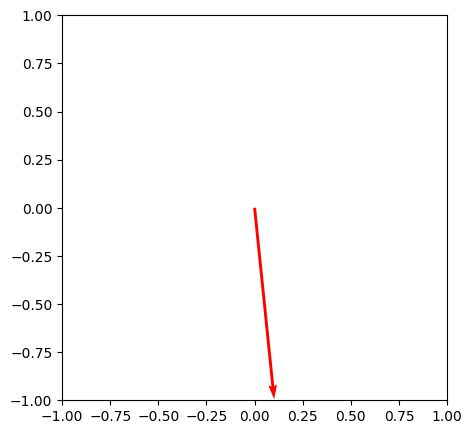

In [64]:
get_pt_from_steer_angle_and_plot_as_vector(sample_1_selected_row_1['action_steer'][35621], ax=None)

In [65]:
def plot_scan_and_vectors(scan, pt1_red, pt2_green, ax=None, rot=False):
    ax = vis_lidar(scan, ax=ax, rot=rot)
    ax = get_pt_from_steer_angle_and_plot_as_vector(pt1_red, ax=ax, color='r', rot=rot)
    ax = get_pt_from_steer_angle_and_plot_as_vector(pt2_green, ax=ax, color='g', rot=rot)
    return ax

/tmp/ipykernel_7629/3540318241.py:48: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-3.5, 3,5)


<AxesSubplot: >

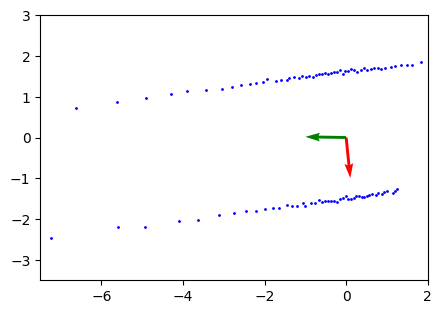

In [66]:
plot_scan_and_vectors(sample_1_selected_row_1_lidar, sample_1_selected_row_1['action_steer'][35621], sample_1_selected_row_2['action_steer'][35618])

In [67]:
sample_5

,conflict_idx,lidar,action_steer,action_speed
25504,4274,"[2.93540902, 2.7944832, 2.71234297, 2.68404524...",1.515918,6.862254
25505,4274,"[2.88603138, 2.81987164, 2.74682491, 2.7238649...",0.033607,8.000000
25506,4274,"[2.86524177, 2.85837241, 2.75614632, 2.7065212...",0.033607,8.000000
25507,4274,"[2.93653515, 2.85256687, 2.75106953, 2.7230271...",0.033607,8.000000


/tmp/ipykernel_7629/3540318241.py:48: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-3.5, 3,5)


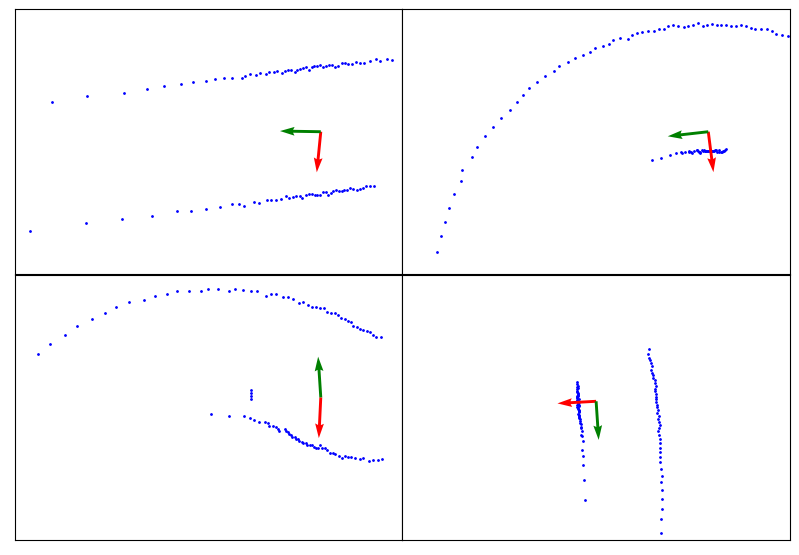

In [81]:
# Make 4 subplot and plot the 4 samples
fig, axarr = plt.subplots(2, 2, figsize=(10,6.9))
#axarr[0, 0].set_title('Sample 1')
axarr[0, 0] = plot_scan_and_vectors(sample_1['lidar'][35618], sample_1['action_steer'][35621], sample_1['action_steer'][35618], ax=axarr[0, 0])
#axarr[0, 1].set_title('Sample 2')
axarr[0, 1] = plot_scan_and_vectors(sample_2['lidar'][123324], sample_2['action_steer'][123325], sample_2['action_steer'][123324], ax=axarr[0, 1])
#axarr[1, 0].set_title('Sample 3')
axarr[1, 0] = plot_scan_and_vectors(sample_4['lidar'][86045], sample_4['action_steer'][86042], sample_4['action_steer'][86045], ax=axarr[1, 0])
#axarr[1, 1].set_title('Sample 4')
axarr[1, 1] = plot_scan_and_vectors(sample_5['lidar'][25504], sample_5['action_steer'][25504], sample_5['action_steer'][25507], ax=axarr[1, 1], rot=True)

# hide axes ticks in all sub plots
axarr[0, 0].xaxis.set_visible(False)
axarr[0, 0].yaxis.set_visible(False)
axarr[1, 1].xaxis.set_visible(False)
axarr[1, 1].yaxis.set_visible(False)
axarr[1, 0].xaxis.set_visible(False)
axarr[1, 0].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)
axarr[0, 1].yaxis.set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)


# Comparison after fixing number of samples

In [2]:
cbf_filtered_01 = pd.read_csv('fixed_training_ds_length_comp/0.1_cbf_filtered.csv')
random_truncated_01 = pd.read_csv('fixed_training_ds_length_comp/0.1_random_truncate.csv')

cbf_filtered_02 = pd.read_csv('fixed_training_ds_length_comp/0.2_cbf_filtered.csv')
random_truncated_02 = pd.read_csv('fixed_training_ds_length_comp/0.2_random_truncate.csv')

cbf_filtered_03 = pd.read_csv('fixed_training_ds_length_comp/0.3_cbf_filtered.csv')
random_truncated_03 = pd.read_csv('fixed_training_ds_length_comp/0.3_random_truncate.csv')

cbf_filtered_04 = pd.read_csv('fixed_training_ds_length_comp/0.4_cbf_filtered.csv')
random_truncated_04 = pd.read_csv('fixed_training_ds_length_comp/0.4_random_truncate.csv')

cbf_filtered_05 = pd.read_csv('fixed_training_ds_length_comp/0.5_cbf_filtered.csv')
random_truncated_05 = pd.read_csv('fixed_training_ds_length_comp/0.5_random_truncate.csv')

cbf_filtered_06 = pd.read_csv('fixed_training_ds_length_comp/0.6_cbf_filtered.csv')
random_truncated_06 = pd.read_csv('fixed_training_ds_length_comp/0.6_random_truncate.csv')

cbf_filtered_07 = pd.read_csv('fixed_training_ds_length_comp/0.7_cbf_filtered.csv')
random_truncated_07 = pd.read_csv('fixed_training_ds_length_comp/0.7_random_truncate.csv')

cbf_filtered_08 = pd.read_csv('fixed_training_ds_length_comp/0.8_cbf_filtered.csv')
random_truncated_08 = pd.read_csv('fixed_training_ds_length_comp/0.8_random_truncate.csv')

cbf_filtered_09 = pd.read_csv('fixed_training_ds_length_comp/0.9_cbf_filtered.csv')
random_truncated_09 = pd.read_csv('fixed_training_ds_length_comp/0.9_random_truncate.csv')

cbf_filtered_10 = pd.read_csv('fixed_training_ds_length_comp/1.0_cbf_filtered.csv')
random_truncated_10 = pd.read_csv('fixed_training_ds_length_comp/1.0_random_truncate.csv')

In [3]:
cbf_filtered_01["undesired_overtaking_behavior_prob"] = 0.1
cbf_filtered_02["undesired_overtaking_behavior_prob"] = 0.2
cbf_filtered_03["undesired_overtaking_behavior_prob"] = 0.3
cbf_filtered_04["undesired_overtaking_behavior_prob"] = 0.4
cbf_filtered_05["undesired_overtaking_behavior_prob"] = 0.5
cbf_filtered_06["undesired_overtaking_behavior_prob"] = 0.6
cbf_filtered_07["undesired_overtaking_behavior_prob"] = 0.7
cbf_filtered_08["undesired_overtaking_behavior_prob"] = 0.8
cbf_filtered_09["undesired_overtaking_behavior_prob"] = 0.9
cbf_filtered_10["undesired_overtaking_behavior_prob"] = 1.0

random_truncated_01["undesired_overtaking_behavior_prob"] = 0.1
random_truncated_02["undesired_overtaking_behavior_prob"] = 0.2
random_truncated_03["undesired_overtaking_behavior_prob"] = 0.3
random_truncated_04["undesired_overtaking_behavior_prob"] = 0.4
random_truncated_05["undesired_overtaking_behavior_prob"] = 0.5
random_truncated_06["undesired_overtaking_behavior_prob"] = 0.6
random_truncated_07["undesired_overtaking_behavior_prob"] = 0.7
random_truncated_08["undesired_overtaking_behavior_prob"] = 0.8
random_truncated_09["undesired_overtaking_behavior_prob"] = 0.9
random_truncated_10["undesired_overtaking_behavior_prob"] = 1.0


In [10]:
cbf_filtered_01['method'] = 'Unsafe data filter'
cbf_filtered_02['method'] = 'Unsafe data filter'
cbf_filtered_03['method'] = 'Unsafe data filter'
cbf_filtered_04['method'] = 'Unsafe data filter'
cbf_filtered_05['method'] = 'Unsafe data filter'
cbf_filtered_06['method'] = 'Unsafe data filter'
cbf_filtered_07['method'] = 'Unsafe data filter'
cbf_filtered_08['method'] = 'Unsafe data filter'
cbf_filtered_09['method'] = 'Unsafe data filter'
cbf_filtered_10['method'] = 'Unsafe data filter'

random_truncated_01['method'] = 'Random truncation'
random_truncated_02['method'] = 'Random truncation'
random_truncated_03['method'] = 'Random truncation'
random_truncated_04['method'] = 'Random truncation'
random_truncated_05['method'] = 'Random truncation'
random_truncated_06['method'] = 'Random truncation'
random_truncated_07['method'] = 'Random truncation'
random_truncated_08['method'] = 'Random truncation'
random_truncated_09['method'] = 'Random truncation'
random_truncated_10['method'] = 'Random truncation'

In [11]:
concat_df = pd.concat([cbf_filtered_01, cbf_filtered_02, cbf_filtered_03, cbf_filtered_04, cbf_filtered_05, cbf_filtered_06, cbf_filtered_07, cbf_filtered_08, cbf_filtered_09, cbf_filtered_10, random_truncated_01, random_truncated_02, random_truncated_03, random_truncated_04, random_truncated_05, random_truncated_06, random_truncated_07, random_truncated_08, random_truncated_09, random_truncated_10])
concat_df

,model_idx,avg_collision_rate,avg_overtake_rate,undesired_overtaking_behavior_prob,method
0,100,0.64,0.32,0.1,Unsafe data filter
1,200,0.57,0.43,0.1,Unsafe data filter
2,300,0.53,0.47,0.1,Unsafe data filter
3,400,0.58,0.37,0.1,Unsafe data filter
4,500,0.63,0.37,0.1,Unsafe data filter
...,...,...,...,...,...
5,600,0.97,0.00,1.0,Random truncation
6,700,0.95,0.00,1.0,Random truncation
7,800,0.98,0.00,1.0,Random truncation
8,900,0.97,0.00,1.0,Random truncation


In [12]:
comp_1000_steps_df = concat_df[concat_df["model_idx"] == 1000]
comp_1000_steps_df

,model_idx,avg_collision_rate,avg_overtake_rate,undesired_overtaking_behavior_prob,method
9,1000,0.43,0.57,0.1,Unsafe data filter
9,1000,0.45,0.55,0.2,Unsafe data filter
9,1000,0.48,0.52,0.3,Unsafe data filter
9,1000,0.53,0.47,0.4,Unsafe data filter
9,1000,0.57,0.43,0.5,Unsafe data filter
9,1000,0.58,0.42,0.6,Unsafe data filter
9,1000,0.59,0.41,0.7,Unsafe data filter
9,1000,0.58,0.42,0.8,Unsafe data filter
8,1000,0.68,0.32,0.9,Unsafe data filter
9,1000,0.71,0.29,1.0,Unsafe data filter


<AxesSubplot: xlabel='undesired_overtaking_behavior_prob', ylabel='avg_overtake_rate'>

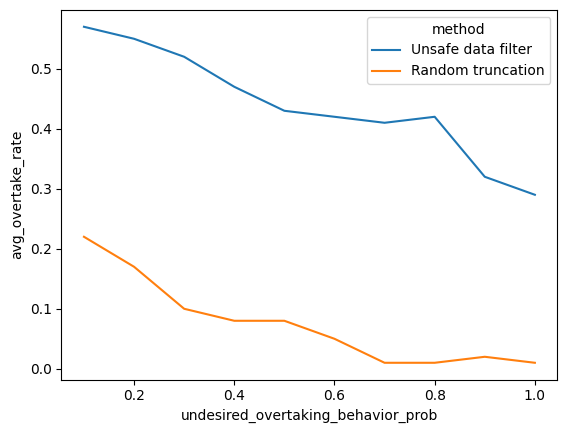

In [13]:
sns.lineplot(data=comp_1000_steps_df, x="undesired_overtaking_behavior_prob", y="avg_overtake_rate", hue="method")

<AxesSubplot: xlabel='undesired_overtaking_behavior_prob', ylabel='avg_collision_rate'>

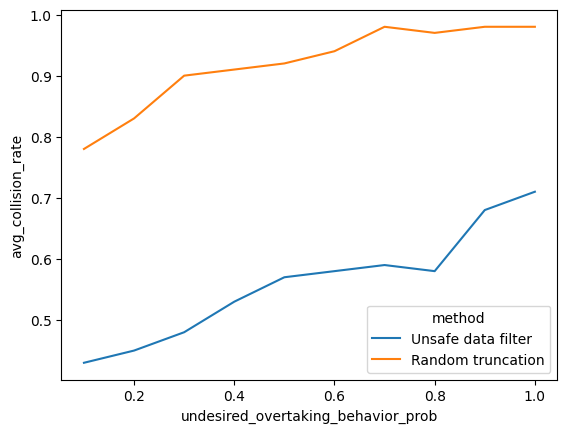

In [14]:
sns.lineplot(data=comp_1000_steps_df, x="undesired_overtaking_behavior_prob", y="avg_collision_rate", hue="method")

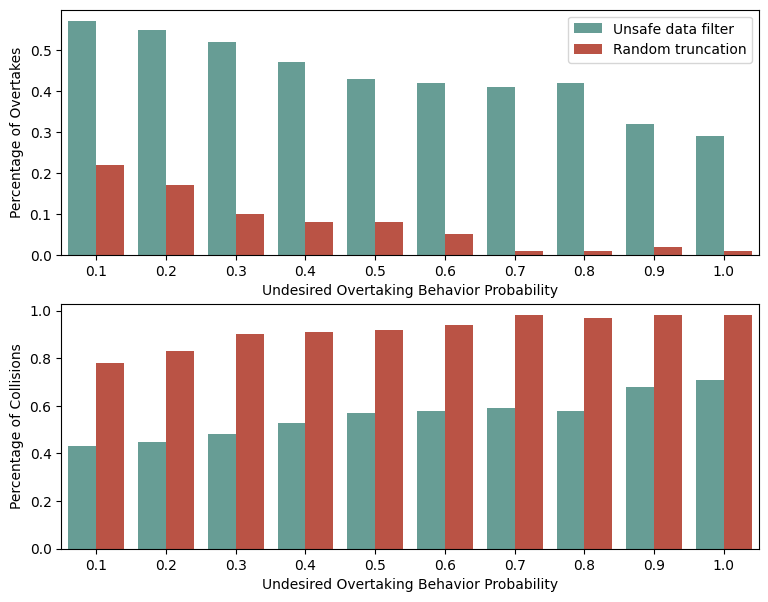

In [17]:
fig2, axarr2 = plt.subplots(2, 1, figsize=(9, 7))
a = sns.barplot(data=comp_1000_steps_df, x="undesired_overtaking_behavior_prob", y="avg_overtake_rate", hue="method", palette= ["#5EA69C", "#CD4432"], ax=axarr2[0])
a.set_xlabel('Expert Undesired Overtaking Behavior Rate')
a.set_ylabel('Percentage of Overtakes')

a_legend = a.get_legend()
a_legend.set_title('')
#a.legend(['', ''])
a.set_xticklabels(['0.29', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])

b = sns.barplot(data=comp_1000_steps_df, x="undesired_overtaking_behavior_prob", y="avg_collision_rate", hue="method", palette= ["#5EA69C", "#CD4432"], ax=axarr2[1])
b.set_xlabel('Expert Undesired Overtaking Behavior Rate')
b.set_ylabel('Percentage of Collisions')
b.get_legend().remove()